In [3]:
import xarray as xr
from calculate_exposure_to_haz import INPUT_DIR, EXPOSURES_DIR, get_exposures
import numpy as np
exposures_dict = get_exposures(haz_type='EP')


In [4]:
import pandas as pd
import numpy as np
from climada.hazard import Hazard
import xarray as xr
from calculate_exposure_to_haz import *
# Rename columns

# Extract years from the `time` dimension

# Initialize an empty list to store the hazards
yearly_hazards = {}

# Loop over each unique year
for year in np.arange(2003,2022):
    file =INPUT_DIR / f"extreme_precip/monthly_max/thresholdprecip_99_9_era5land_remapped_0.25_monthly_max_{year}.nc"
    precip = xr.open_dataset(file)
    precip_monthly = precip.resample(time='M').max()
    precip_monthly['lon'] = precip_monthly['lon'].where(precip_monthly['lon'] <= 180, precip_monthly['lon'] - 360)
    precip_monthly = precip_monthly.rename({'lon': 'longitude','lat': 'latitude'})
    # Convert it into a hazard
    yearly_hazard = Hazard.from_xarray_raster(precip_monthly, hazard_type='EP', intensity_unit='mm', intensity='tp')
    yearly_hazard.intensity.eliminate_zeros()
    # Append the hazard to the list

    yearly_hazards[year] = yearly_hazard



<GeoAxes: title={'center': 'Event ID 12: 2021-12-31T00:00:00.000000000'}>

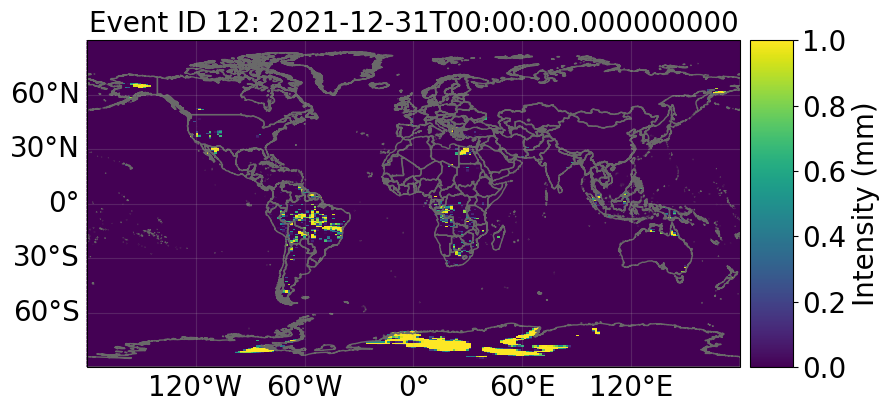

In [5]:
yearly_hazard.plot_intensity(12)

In [6]:
data = yearly_hazard.intensity[yearly_hazard.intensity>0]

(array([5.2323e+04, 8.2104e+04, 1.3022e+04, 1.3936e+04, 3.2670e+03,
        5.5300e+02, 3.0800e+02, 8.5000e+01, 2.9000e+01, 6.0000e+00]),
 array([0.01700015, 0.6393019 , 1.26160359, 1.88390529, 2.50620699,
        3.12850881, 3.75081062, 4.3731122 , 4.99541378, 5.61771584,
        6.24001741]),
 <BarContainer object of 10 artists>)

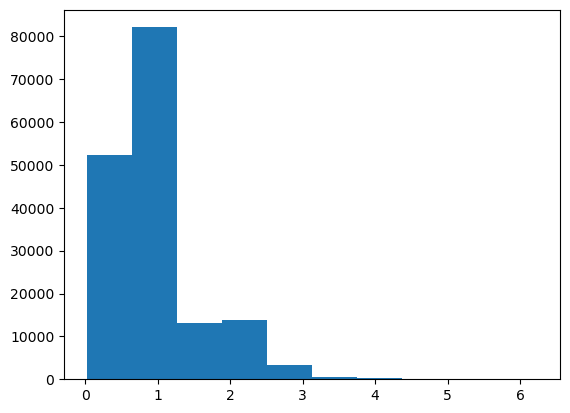

In [7]:
import matplotlib.pyplot as plt
data = yearly_hazard.intensity.sum(axis=0)
plt.hist(np.asarray(data[data>0])[0])

In [8]:
from climada.entity.impact_funcs import ImpactFunc, ImpactFuncSet

impf_set = ImpactFuncSet()

impfhw = ImpactFunc()
impfhw.id = 1
impfhw.haz_type = 'EP'
impfhw.name = 'function EP'
impfhw.intensity_unit = ''
impfhw.intensity = np.array([0, 0.5, 1])
impfhw.mdd = np.array([0, 0.5, 1])
impfhw.paa = np.ones(impfhw.intensity.shape)
impfhw.check()
impf_set.append(impfhw)

In [9]:
from climada.engine import Impact, ImpactCalc

impact_dict={age:{year:ImpactCalc(exposures_dict[age][str(year)], impf_set, yearly_hazards[int(year)]).impact(save_mat=True) for year in yearly_hazards} for age in exposures_dict}
impact_dict_no_change_vuln_pop={age:{year:ImpactCalc(exposures_dict[age]['2003'], impf_set, yearly_hazards[year]).impact(save_mat=True) for year in yearly_hazards} for age in exposures_dict}


In [10]:
for age in impact_dict_no_change_vuln_pop:
    for year in impact_dict_no_change_vuln_pop[age]:
        impact_dict[age][year].tot_value=0
        impact_dict_no_change_vuln_pop[age][year].tot_value=0


2024-08-22 11:19:23,694 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-22 11:19:23,700 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-22 11:19:23,701 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-22 11:19:23,702 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-22 11:19:23,703 - climada.engine.impact - WARNING - The 

In [11]:
impact_concat = {}
impact_concat_no_change_vuln_pop = {}
for age in impact_dict_no_change_vuln_pop:
    impact_concat[age] = Impact.concat(list(impact_dict[age].values()),reset_event_ids=True)
    impact_concat_no_change_vuln_pop[age] = Impact.concat(list(impact_dict_no_change_vuln_pop[age].values()),reset_event_ids=True)

2024-08-22 11:19:23,792 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-22 11:19:23,794 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-22 11:19:23,795 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-22 11:19:23,795 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-22 11:19:23,796 - climada.engine.impact - WARNING - The 

In [ ]:
from calculate_exposure_to_haz import *


from climada.engine import Impact, ImpactCalc
impact_concat = {}
impact_concat_no_change_vuln_pop = {}
for age in impact_dict_no_change_vuln_pop:
    impact_concat[age] = Impact.concat(list(impact_dict[age].values()),reset_event_ids=True)
    impact_concat_no_change_vuln_pop[age] = Impact.concat(list(impact_dict_no_change_vuln_pop[age].values()),reset_event_ids=True)
    write_impact(impact_concat[age], 'EP', age)
    write_impact(impact_concat_no_change_vuln_pop[age], 'EP_ec', age)



2024-08-22 11:21:08,433 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-22 11:21:08,435 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-22 11:21:08,436 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-22 11:21:08,436 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-08-22 11:21:08,437 - climada.engine.impact - WARNING - The 